#Read me
This code will take about 1 hour to run on Google Colab premium A100 GPU.

This code uses about 22 GB of VRAM because of the data agumentation process.

To run this notebook, you have to upload a file called `data.zip` to the run time which contains the full clocks dataset (image size 150x150).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import keras
from sklearn.model_selection import train_test_split
import zipfile
import os
from tensorflow.keras.utils import to_categorical
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Load the data

In [ ]:
# WAIT until the zip file has been fully uploaded

# Import the full file (18k images)
import zipfile
import os

file_path = '/content/data.zip'

try:
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        extract_path = '/content/data'
        os.makedirs(extract_path, exist_ok=True)
        zip_ref.extractall(extract_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except zipfile.BadZipFile:
    print(f"Error: Invalid zip file at {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
images = np.load('data/images.npy')
labels = np.load('data/labels.npy')

# Test val test split

In [ ]:
#Split into 60% training 40% test + val
X_train_images, X_temp, y_train, y_temp = train_test_split(images, labels,test_size=0.4, random_state=42, shuffle=True)

#Split test+val 50% -> 20% each
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

In [ ]:
#Labels on a string format like "11:01"
y_train_string = []
for i in y_train:
  y_train_string.append(f"{i[0]}:{i[1]}")

In [ ]:
#Same for val and test labels
y_val_string = []
for i in y_val:
  y_val_string.append(f"{i[0]}:{i[1]}")

y_test_string = []
for i in y_test:
  y_test_string.append(f"{i[0]}:{i[1]}")

#Data Augmentation

In [ ]:
#Dictionary to store indices of labels
labels_dict = {}
for idx,label in enumerate(y_train_string):
  if label in labels_dict.keys():
    labels_dict[label] += [idx]
  else:
    labels_dict[label] = [idx]

In [ ]:
#Function to augmentate data by scale_factor, augmented images will be randomly rotated from -360 to 360, with zoom from 90% to 110% and up to 15% shear
def augmentate_data(scale_factor):
  #Images with the channel dimension
  images_plus1 = X_train_images.reshape(X_train_images.shape+(1,))
  img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360,zoom_range=[0.9, 1.1],shear_range=15,data_format="channels_last",dtype=np.uint8)

  all_images = []
  y_train_augmented_string = []

  for i,label in enumerate(labels_dict.keys()):
    images_flow = img_gen.flow(images_plus1[labels_dict[label]], batch_size=25)
    for idx,imgs in enumerate(images_flow):
      all_images.extend(imgs)
      for j in range(len(imgs)):
        y_train_augmented_string.append(label)

      if idx >= (scale_factor -1):
        break
  return  np.array(np.squeeze(all_images)),np.array(y_train_augmented_string)

Scale training data by a factor of 25

In [ ]:
X_train_augmented,y_train_augmented_string=augmentate_data(25)

#Prepare the data

In [ ]:
#Turn the augmented labels back
y_train_augmented = []
for i in y_train_augmented_string:
  y_train_augmented.append([int(x) for x in i.split(':')])

y_train_augmented = np.array(y_train_augmented)
y_train_augmented.shape

(270000, 2)

In [ ]:
#Later we will need the images as rgb
images_tensor = tf.convert_to_tensor(X_train_augmented, dtype=tf.uint8)
images_tensor = tf.expand_dims(images_tensor, axis=-1)
X_train = tf.image.grayscale_to_rgb(images_tensor)
X_train.shape


TensorShape([270000, 150, 150, 3])

In [ ]:
#Same for test and val images
images_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.uint8)
images_val_tensor = tf.expand_dims(images_val_tensor, axis=-1)
X_val = tf.image.grayscale_to_rgb(images_val_tensor)

images_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.uint8)
images_test_tensor = tf.expand_dims(images_test_tensor, axis=-1)
X_test = tf.image.grayscale_to_rgb(images_test_tensor)
X_test.shape

TensorShape([3600, 150, 150, 3])

##Prepare data for multi-head classification and classification

In [ ]:
#We need to separete labels into labels_hours and labels_minutes for each dataset
y_train_hours_augmented = [x[0] for x in y_train_augmented]
y_train_minutes_augmented = [x[1] for x in y_train_augmented]

y_val_hours = [x[0] for x in y_val]
y_val_minutes = [x[1] for x in y_val]

y_test_hours = [x[0] for x in y_test]
y_test_minutes = [x[1] for x in y_test]

In [ ]:
#As we are doing classification for hours we need to onehot encode all the hours labels

y_train_hours_one_hot = to_categorical(y_train_hours_augmented)
y_train_minutes_one_hot = to_categorical(y_train_minutes_augmented)


y_test_hours_one_hot = to_categorical(y_test_hours)
y_test_minutes_one_hot = to_categorical(y_test_minutes)

y_val_hours_one_hot = to_categorical(y_val_hours)
y_val_minutes_one_hot = to_categorical(y_val_minutes)

# Convert to tensors
y_train_hours_one_hot = tf.convert_to_tensor(y_train_hours_one_hot)
y_train_minutes_one_hot = tf.convert_to_tensor(y_train_minutes_one_hot)

y_val_hours_one_hot = tf.convert_to_tensor(y_val_hours_one_hot)
y_val_minutes_one_hot = tf.convert_to_tensor(y_val_minutes_one_hot)

y_test_hours_one_hot = tf.convert_to_tensor(y_test_hours_one_hot)
y_test_minutes_one_hot = tf.convert_to_tensor(y_test_minutes_one_hot)



# Display the shapes of the splits
print(f'Train set hours shape: X: {X_train.shape}, y: {y_train_hours_one_hot.shape}')
print(f'Validation set hours shape: X: {X_val.shape}, y: {y_val_hours_one_hot.shape}')
print(f'Test set hours shape: X: {X_test.shape}, y: {y_test_hours_one_hot.shape}')

print(f'Train set minutes shape: X: {X_train.shape}, y: {y_train_minutes_one_hot.shape}')
print(f'Validation set minutes shape: X: {X_val.shape}, y: {y_val_minutes_one_hot.shape}')
print(f'Test set minutes shape: X: {X_test.shape}, y: {y_test_minutes_one_hot.shape}')


Train set hours shape: X: (270000, 150, 150, 3), y: (270000, 12)
Validation set hours shape: X: (3600, 150, 150, 3), y: (3600, 12)
Test set hours shape: X: (3600, 150, 150, 3), y: (3600, 12)
Train set minutes shape: X: (270000, 150, 150, 3), y: (270000, 60)
Validation set minutes shape: X: (3600, 150, 150, 3), y: (3600, 60)
Test set minutes shape: X: (3600, 150, 150, 3), y: (3600, 60)


##Transfer Learning for Multi-head Classification Classification

In [ ]:
image_size = X_train.shape[1]
base_model = VGG16(include_top = False,
                       weights = 'imagenet',
                       input_shape = (image_size, image_size, 3))
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Check the parameter count
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x1 = Dropout(0.5)(x)
x2 = Dropout(0.6)(x)

# Seperate layer for minutes
x2_minute = Dense(256, activation='relu')(x2)
x2_minute = BatchNormalization()(x2_minute)
x2_minute = Dropout(0.7)(x2_minute)
minute_output = Dense(60, activation='softmax', name='minute_output')(x2_minute)

hour_output = keras.layers.Dense(12, activation='softmax',name='hour_output')(x1)

model = Model(inputs=base_model.inputs, outputs=[hour_output,minute_output])

# Small learning rate to only slightly adjust the weights
# Use categorical cross entropy since we have one hot encoded the response 'categorical_crossentropy'
# Separate weight decay rates for minutes and hours
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'hour_output':'categorical_crossentropy','minute_output':'categorical_crossentropy'},
              metrics={'hour_output':['accuracy'],'minute_output':['accuracy']})

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 150, 150, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 150, 150, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 75, 75, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 75, 75, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 75, 75, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 37, 37, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 37, 37, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 37, 37, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 37, 37, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 18, 18, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 18, 18, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 18, 18, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 18, 18, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 9, 9, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 9, 9, 512)      │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 9, 9, 512)      │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 15,133,320 (57.73 MB)

 Trainable params: 5,136,712 (19.60 MB)

 Non-trainable params: 9,996,608 (38.13 MB)

In [ ]:
model_name = "model_best.h5.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 9, verbose = 1, restore_best_weights=True)

# Reduce learning rate if model plateus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [ ]:
try:
  history = model.fit(X_train, {'hour_output': y_train_hours_one_hot, 'minute_output': y_train_minutes_one_hot},
                        epochs=30,
                        batch_size=128,
                        validation_data=(X_val, {'hour_output': y_val_hours_one_hot, 'minute_output': y_val_minutes_one_hot}),
                        callbacks=[checkpoint,earlystopping,reduce_lr]
                       )
except KeyboardInterrupt:
    print("\nTraining Stopped")

Epoch 1/30
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - hour_output_accuracy: 0.1901 - loss: 6.8058 - minute_output_accuracy: 0.0327
Epoch 1: val_loss improved from inf to 4.22787, saving model to model_best.h5.keras
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 97s 36ms/step - hour_output_accuracy: 0.1902 - loss: 6.8052 - minute_output_accuracy: 0.0327 - val_hour_output_accuracy: 0.4694 - val_loss: 4.2279 - val_minute_output_accuracy: 0.1247 - learning_rate: 0.0010
Epoch 2/30
2109/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - hour_output_accuracy: 0.6936 - loss: 3.3411 - minute_output_accuracy: 0.1526
Epoch 2: val_loss improved from 4.22787 to 1.99621, saving model to model_best.h5.keras
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 58s 27ms/step - hour_output_accuracy: 0.6936 - loss: 3.3407 - minute_output_accuracy: 0.1526 - val_hour_output_accuracy: 0.9203 - val_loss: 1.9962 - val_minute_output_accuracy: 0.2869 - learning_rate: 0.0010
Epoch 3/30
2109/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - hour_output_accuracy: 0.9

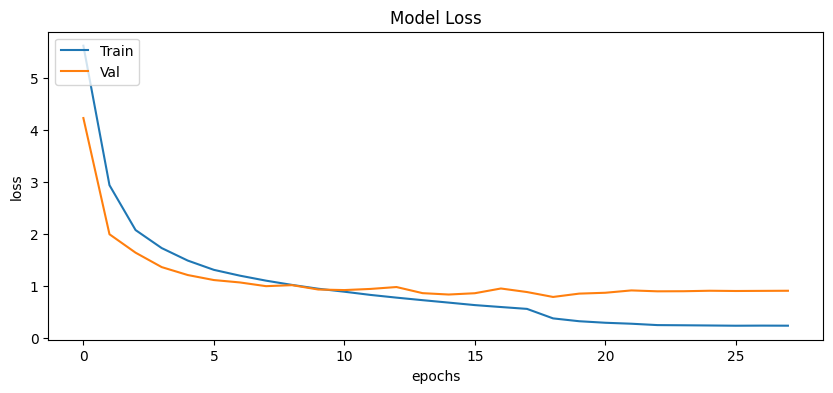

In [ ]:
# Plot loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train','Val'], loc= 'upper left')
plt.show()

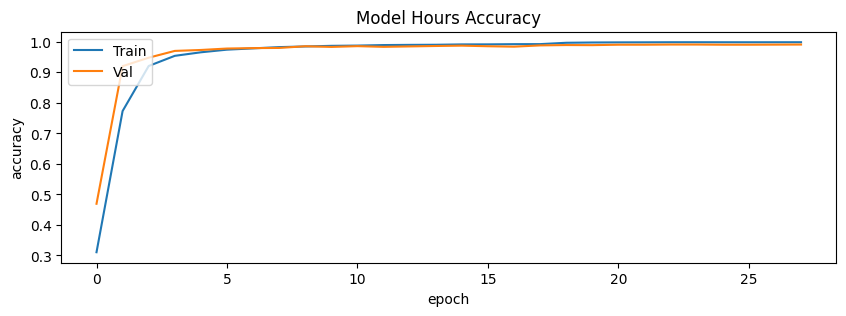

In [ ]:
# Plot Hours accuracy
plt.figure(figsize=(10,3))
plt.plot(history.history['hour_output_accuracy'])
plt.plot(history.history['val_hour_output_accuracy'])
plt.title('Model Hours Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

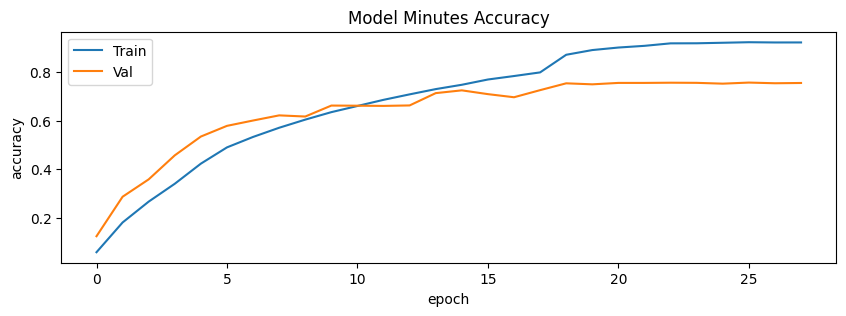

In [ ]:
# Plot minutes accuracy
plt.figure(figsize=(10,3))
plt.plot(history.history['minute_output_accuracy'])
plt.plot(history.history['val_minute_output_accuracy'])
plt.title('Model Minutes Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

##Model Evaluation

In [ ]:
model.evaluate(X_test, {'hour_output': y_test_hours_one_hot, 'minute_output': y_test_minutes_one_hot})

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - hour_output_accuracy: 0.9882 - loss: 0.7883 - minute_output_accuracy: 0.7741


[0.7608338594436646, 0.988611102104187, 0.7705555558204651]

In [ ]:
y_pred = model.predict(X_test)
predicted_hours = np.argmax(y_pred[0], axis=1)
predicted_minutes = np.argmax(y_pred[1], axis=1)
y_pred =predicted_hours*60+predicted_minutes


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


In [ ]:
type(y_pred)

numpy.ndarray

In [ ]:
y_test_hours = np.array(y_test_hours)*60
y_test = y_test_hours+np.array(y_test_minutes)


In [ ]:
def common_sense(true,pred):
      diff=abs(true-pred)
      return min(diff,720-diff)

In [ ]:
common_sense_mins = [None] * len(y_test)
for idx in range(len(y_test)):
    diff = common_sense(y_test[idx],y_pred[idx])
    common_sense_mins[idx] = diff

mean_common_sense_mins = np.mean(common_sense_mins)
print(f"Minutes = Mean common sense: {mean_common_sense_mins}")

Minutes = Mean common sense: 1.0216666666666667
